<a href="https://colab.research.google.com/github/SriSatyaLokesh/some-app-for-whatsapp/blob/master/notebooks/analytics/Word_Generator_demo-Vasavi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()

Saving wanalyzer1.jpg to wanalyzer1.jpg


In [1]:
import pandas as pd
from itertools import chain, repeat
from string import digits
import re

chainer = chain.from_iterable
class Cleaner:
  def __init__(self,filename):
    self.filename = filename

  def _clean_data(self):
    """ 
    What it does?
    ----------------
      remove action messages and append new line without date format to previous message
      
      EXAMPLE : 
      17/07/19, 8:33 pm - +91 90633 88499: Sir,
      *We have a chance to write Cocubes exam later...?*
      CHANGED TO:
      17/07/19, 8:33 pm - +91 90633 88499: Sir, *We have a chance to write Cocubes exam later...?*
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      raw_texts : list
                  list consists of all raw messages ignoring actions from the chat file
      
    """
    chat_file = self.filename
    with open(chat_file) as file:
      all_msgs = file.readlines()
      raw_texts = []
      for line in all_msgs:
        if re.match("^\d{2}/\d{2}/\d{2,4},\s\d{1,2}:\d{2}\s[ap]*[m]*",line):
          date_split = line.split(' - ') 
          user_split = date_split[1].split(':')
          if len(user_split) >= 2:
            raw_texts.append(line)
        else:
          try:
            raw_texts[-1] += line
          except Exception as err:
            print(line,raw_texts)
            print(err)

    return raw_texts 
      
  def _get_data(self):
    """ 
    What it does?
    ----------------
      Import whatsapp data and transform it to a dataframe
      
      Parameters:
      -----------
      -
          
      Returns:
      --------
      df : dataframe
          Dataframe of all messages with columns - ["users", "raw_text"]
      
    """
    raw_texts = self._clean_data()
    raw_messages = dict()
    for line in raw_texts:
      date_split = line.split(' - ')
      user_split = date_split[1].split(':')
      user = user_split[0]
      if user not in raw_messages:
        raw_messages[user] = [line]
      else:
        raw_messages[user].append(line)
    df = pd.DataFrame({'user': list(chainer(repeat(k, len(v)) for k,v in raw_messages.items())),
                   'raw_text': list(chainer(raw_messages.values()))}) 
    return df

  def _get_message(self,df):
    """ 
    What it does?
    ----------------
      new column is added to existing dataframe i.e clean_message which ignores datetime and user from the raw_message
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      df : dataframe
          Dataframe of all messages with columns - ["users", "raw_text", "raw_message",]
      
    """
    df["raw_message"] = df.apply(lambda df : "".join(df['raw_text'].split(":")[2:]),axis=1)
    df["raw_message"] = df.apply(lambda df : df['raw_message'][:-1],axis=1)
    return df

  def _get_text_only_message(self,df):
    """ 
    What it does?
    ----------------
      new column is added to existing dataframe i.e text_only_message which ignores all emojis and numbers from the clean_message
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      df : dataframe
          Dataframe of all messages with columns - ["users", "raw_text", "raw_message", "text_only_message"]
      
    """
    remove_digits = str.maketrans('', '', digits)
    df["text_only_message"] = df.apply(lambda df : df["raw_message"].encode('ascii', 'ignore').decode('ascii'),axis=1)     # removing emoji s from cleam_message
    df["text_only_message"] = df.apply(lambda df : df["text_only_message"].translate(remove_digits),axis=1)          # removing digits from clean_message

    df.loc[(df['text_only_message'] == " This message was deleted") | (df['text_only_message'] == " <Media omitted>"),'text_only_message'] = "" # updating "This message was deleted" & "media" to ""(empty_string)

    return df

  def _remove_inactive_users(self,df):
    """ 
    What it does?
    ----------------
      removes inactive users i.e user with no of messages < 10 from dataframe
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      df : dataframe
          Dataframe of all messages with columns - ["users", "raw_text", "raw_message", "text_only_message"]
          removing inactive users
      
    """
    df = df.groupby('user').filter(lambda x : len(x) > 10)
    return df

  def _get_user_media_counts(self,df):
    """ 
    What it does?
    ----------------
      it counts individual user media that is sent in the chat
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      user_media_counts : dictionary
                          key as 'user' : value as 'media_count'
      
    """
    media_count = df[df['raw_message'] == " <Media omitted>"].groupby('user').size()
    user_media_counts = media_count.to_dict()
    return user_media_counts

  def _get_datetime(self,df):
    """ 
    What it does?
    ----------------
      3 columns are added i.e 
      
      1. "date" : datetime from raw_text
      2. "hour" : Hour from date column
      3. "weekday" : day of the week from date column 
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      df : dataframe
          Dataframe with only active user messages with columns - ["users", "raw_text", "raw_message", "text_only_message", "date", "hour", "weekday"]
      
    """

    df['date'] =  df.apply(lambda df : df['raw_text'].split(" - ")[0],axis=1)

    temp = ["%d/%m/%Y, %I:%M %p" , "%d/%m/%y, %I:%M %p" , "%d/%m/%Y, %H:%M" , "%d/%m/%y, %H:%M" ,
        "%d/%Y/%m, %I:%M %p" , "%d/%y/%m, %I:%M %p" , "%d/%Y/%m, %H:%M" , "%d/%y/%m, %H:%M" ,
        "%Y/%m/%d, %I:%M %p" , "%y/%m/%d, %I:%M %p" , "%Y/%m/%d, %H:%M" , "%y/%m/%d, %H:%M" ,
        "%Y/%d/%m, %I:%M %p" , "%y/%d/%m, %I:%M %p" , "%Y/%d/%m, %H:%M" , "%y/%d/%m, %H:%M" ,
        "%m/%Y/%d, %I:%M %p" , "%m/%y/%d, %I:%M %p" , "%m/%Y/%d, %H:%M" , "%m/%y/%d, %H:%M" ,
        "%m/%d/%Y, %I:%M %p" , "%m/%d/%y, %I:%M %p" , "%m/%d/%Y, %H:%M" , "%m/%d/%y, %H:%M"]

    for formats in temp:       
      try:
        df['date'] = pd.to_datetime(df['date'], format=formats)
      except:
        continue
    df['hour'] = df['date'].dt.hour
    df['weekday'] = df['date'].dt.weekday
    
    return df

chat_file = 'WhatsApp Chat with IDIOT😎.txt'
clean = Cleaner(chat_file)
df = clean._get_data()
df = clean._get_message(df)
df = clean._get_text_only_message(df)
df = clean._remove_inactive_users(df)
df = clean._get_datetime(df)
df

,user,raw_text,raw_message,text_only_message,date,hour,weekday
0,IDIOT😎,"10/10/19, 9:32 am - IDIOT😎: Naku okasari Whats...",Naku okasari WhatsApp lo msg chey8,Naku okasari WhatsApp lo msg chey,2019-10-10 09:32:00,9,3
1,IDIOT😎,"10/10/19, 9:32 am - IDIOT😎: Malli\n",Malli,Malli,2019-10-10 09:32:00,9,3
2,IDIOT😎,"10/10/19, 9:34 am - IDIOT😎: I'm Groot pedadham...",I'm Groot pedadham ante kudharadam ledhu,I'm Groot pedadham ante kudharadam ledhu,2019-10-10 09:34:00,9,3
3,IDIOT😎,"10/10/19, 9:34 am - IDIOT😎: 😞\n",😞,,2019-10-10 09:34:00,9,3
4,IDIOT😎,"10/10/19, 9:34 am - IDIOT😎: Custom notificatio...",Custom notifications lo na file manager vi ka...,Custom notifications lo na file manager vi ka...,2019-10-10 09:34:00,9,3
...,...,...,...,...,...,...,...
39994,Vasavi,"04/05/20, 4:59 pm - Vasavi: Ledhu\n",Ledhu,Ledhu,2020-05-04 16:59:00,16,0
39995,Vasavi,"04/05/20, 5:00 pm - Vasavi: Em cheya budhi kat...",Em cheya budhi katle,Em cheya budhi katle,2020-05-04 17:00:00,17,0
39996,Vasavi,"04/05/20, 5:00 pm - Vasavi: Inka okati pampav ...",Inka okati pampav ga,Inka okati pampav ga,2020-05-04 17:00:00,17,0
39997,Vasavi,"04/05/20, 5:00 pm - Vasavi: Adhe chusthuna mel...",Adhe chusthuna mellaga,Adhe chusthuna mellaga,2020-05-04 17:00:00,17,0


[For Reference](https://stackoverflow.com/questions/46786211/counting-the-frequency-of-words-in-a-pandas-data-frame)

In [7]:
frequent_words = pd.Series(' '.join(df.text_only_message).split()).value_counts()[:20]
frequent_words

Ha        2770
ga        1385
le        1170
Sare      1160
ra        1147
lo         952
Nenu       840
ki         833
ani        817
Em         797
idiot      786
fellow     688
em         642
kuda       565
aa         477
anta       474
ledhu      433
Haa        417
Naku       381
.          368
dtype: int64

In [3]:
frequent_words = frequent_words.to_dict()
frequent_words

{'.': 368,
 'Em': 797,
 'Ha': 2770,
 'Haa': 417,
 'Naku': 381,
 'Nenu': 840,
 'Sare': 1160,
 'aa': 477,
 'ani': 817,
 'anta': 474,
 'em': 642,
 'fellow': 688,
 'ga': 1385,
 'idiot': 786,
 'ki': 833,
 'kuda': 565,
 'le': 1170,
 'ledhu': 433,
 'lo': 952,
 'ra': 1147}

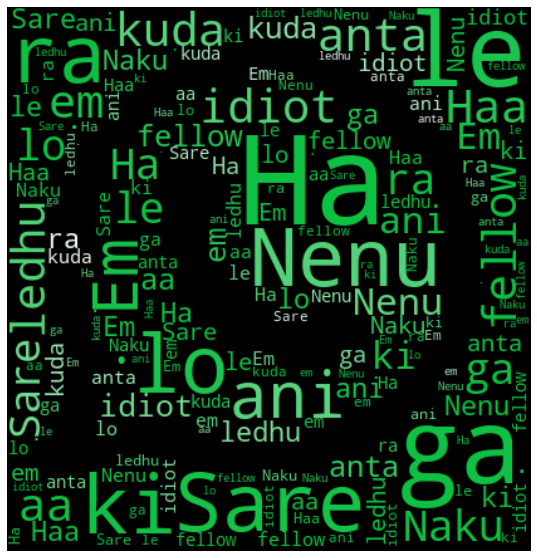

In [9]:
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator

img_mask = np.array(PIL.Image.open("wanalyzer.jpg"))
image_colors = ImageColorGenerator(img_mask)

wordcloud = WordCloud(background_color = 'black',mask = img_mask,random_state=1,repeat=True)
wordcloud.fit_words(frequencies=frequent_words)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()